# All points

torch.Size([6279, 2])
tensor(0.3790)


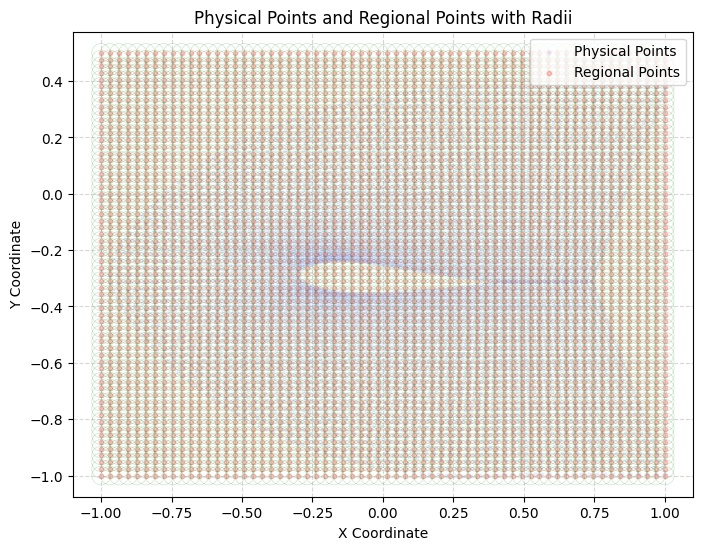

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

import os
import xarray as xr
import sys
import torch

sys.path.append("../../")
from src.model.cmpt.utils.gno_utils import NeighborSearch
from src.graph.support import minimal_support
from src.utils.sample import subsample
from src.utils.scale import rescale

base_path = "/cluster/work/math/camlab-data/"
data = "rigno-unstructured/airfoil_li.nc"
data_path = os.path.join(base_path, data)

data = xr.open_dataset(data_path)

phy_coord = data["x"].values
phy_coord = torch.tensor(phy_coord, dtype=torch.float32)[0,0]
phy_coord = rescale(phy_coord)
print(phy_coord.shape)
print(phy_coord[:,1].max())
# subsample
n = 500
rig_coord = subsample(phy_coord, n=n)
radii = minimal_support(rig_coord, domain_shifts=None)
meshgrid = torch.meshgrid(torch.linspace(-1, 1, 64), 
                                     torch.linspace(-1, 0.5, 64), 
                                     indexing='ij')
rig_coord = torch.stack(meshgrid, dim=-1).reshape(-1,2)

radii = torch.full([rig_coord.shape[0]], 0.033)



# 转换为 NumPy 数组

phy_coord_np = phy_coord.cpu().numpy()#[:9216]
rig_coord_np = rig_coord.cpu().numpy()
radii_np = radii.cpu().numpy()

# 创建绘图
fig, ax = plt.subplots(figsize=(8, 8))

# 绘制物理点
ax.scatter(phy_coord_np[:, 0], phy_coord_np[:, 1], s=5, c='blue', alpha=0.05, label='Physical Points')

# 绘制区域点
ax.scatter(rig_coord_np[:, 0], rig_coord_np[:, 1], s=10, c='red', alpha=0.2, label='Regional Points')

# 创建圆圈集合
patches = []
for (x, y), radius in zip(rig_coord_np, radii_np):
    circle = Circle((x, y), radius)
    patches.append(circle)

# 创建 PatchCollection
p = PatchCollection(patches, facecolor='none', edgecolor='green', alpha=0.2, linewidth=0.5)

# 添加到轴
ax.add_collection(p)

# 设置图例
ax.legend(loc='upper right')

# 设置标题和标签
ax.set_title('Physical Points and Regional Points with Radii')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# 设置比例相同
ax.set_aspect('equal', 'box')

# 显示网格
ax.grid(True, linestyle='--', alpha=0.5)

# 显示图形
plt.show()

# Select Points

物理坐标形状: torch.Size([972, 2])


/cluster/scratch/shiwen/GNPDESolver/tests/vis_graph/../../src/graph/support.py:38: UserWarning: index_reduce() is in beta and the API may change at any time. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1146.)
  radii = torch.index_reduce(radii, 0, indices, values, reduce="amax")


图形已保存到: point_cloud_with_radii_step10.png


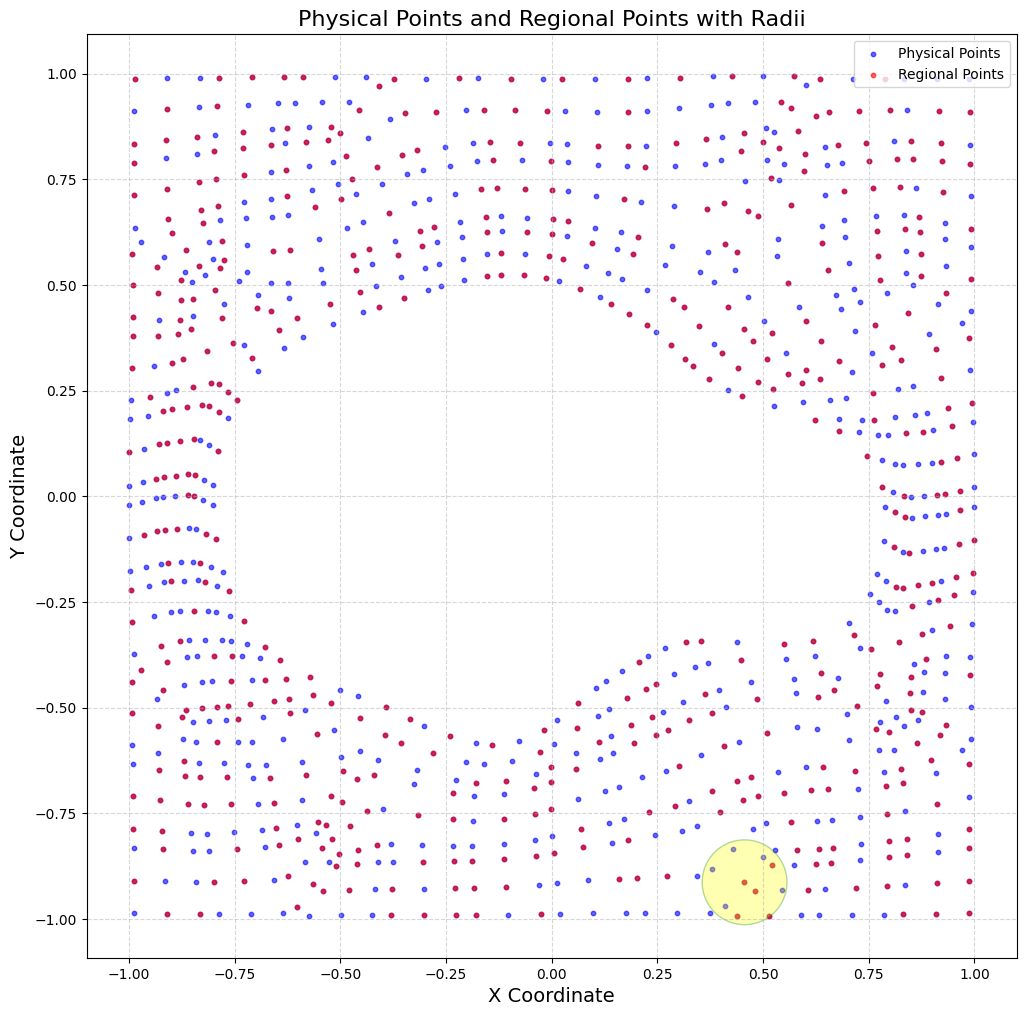

In [1]:
import matplotlib.pyplot as plt
import os
import xarray as xr
import sys
import torch
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from typing import Optional, List

# 假设您的项目结构和导入路径正确
sys.path.append("../../")
from src.model.cmpt.utils.gno_utils import NeighborSearch
from src.graph.support import minimal_support
from src.utils.sample import subsample
from src.utils.scale import rescale

def plot_point_cloud_with_radii(phy_coord: torch.Tensor,
                                rig_coord: torch.Tensor,
                                radii: torch.Tensor,
                                circle_indices: Optional[List[int]] = None,
                                step: int = 10,
                                physical_point_size: int = 10,
                                regional_point_size: int = 10,
                                physical_color: str = 'blue',
                                regional_color: str = 'red',
                                circle_edge_color: str = 'green',
                                circle_face_color: str = 'yellow',
                                circle_alpha: float = 0.2,
                                figsize: tuple = (12, 12),
                                save_path: Optional[str] = None):
    """
    绘制物理点、区域点及其半径范围的圆圈。

    Parameters
    ----------
    phy_coord : torch.Tensor
        物理点坐标，形状为 (num_physical_points, 2) 或 (num_physical_points, 3)。
    rig_coord : torch.Tensor
        区域点坐标，形状为 (num_regional_points, 2) 或 (num_regional_points, 3)。
    radii : torch.Tensor
        每个区域点的半径，形状为 (num_regional_points,)。
    circle_indices : Optional[List[int]], optional
        要绘制圆圈的区域点索引列表。如果为 None，则根据 `step` 参数每隔一定步长绘制一个圆圈。
    step : int, optional
        如果 `circle_indices` 为 None，则每隔 `step` 个区域点绘制一个圆圈。默认值为 10。
    physical_point_size : int, optional
        物理点的大小。默认值为 10。
    regional_point_size : int, optional
        区域点的大小。默认值为 10。
    physical_color : str, optional
        物理点的颜色。默认值为 'blue'。
    regional_color : str, optional
        区域点的颜色。默认值为 'red'。
    circle_edge_color : str, optional
        圆圈边缘的颜色。默认值为 'green'。
    circle_face_color : str, optional
        圆圈填充的颜色。默认值为 'yellow'。
    circle_alpha : float, optional
        圆圈的透明度（0 到 1）。默认值为 0.2。
    figsize : tuple, optional
        图形的大小。默认值为 (12, 12)。
    save_path : Optional[str], optional
        如果指定，则将图形保存到该路径。默认值为 None。
    """
    
    # 确保输入是二维的
    if phy_coord.dim() == 1:
        phy_coord = phy_coord.unsqueeze(1)
    if rig_coord.dim() == 1:
        rig_coord = rig_coord.unsqueeze(1)
    
    # 转换为 NumPy 数组
    phy_coord_np = phy_coord.cpu().numpy()
    rig_coord_np = rig_coord.cpu().numpy()
    radii_np = radii.cpu().numpy()
    
    # 创建绘图
    fig, ax = plt.subplots(figsize=figsize)
    
    # 绘制物理点
    ax.scatter(phy_coord_np[:, 0], phy_coord_np[:, 1], 
               s=physical_point_size, c=physical_color, alpha=0.6, label='Physical Points')
    
    # 绘制区域点
    ax.scatter(rig_coord_np[:, 0], rig_coord_np[:, 1], 
               s=regional_point_size, c=regional_color, alpha=0.6, label='Regional Points')
    
    # 确定要绘制的圆圈索引
    if circle_indices is not None:
        selected_indices = circle_indices
    else:
        selected_indices = list(range(0, len(rig_coord_np), step))
    
    # 创建圆圈集合
    patches = []
    for idx in selected_indices:
        x, y = rig_coord_np[idx]
        radius = radii_np[idx]
        circle = Circle((x, y), radius, 
                        edgecolor=circle_edge_color, 
                        facecolor=circle_face_color, 
                        alpha=circle_alpha)
        patches.append(circle)
    
    # 创建 PatchCollection
    p = PatchCollection(patches, match_original=True)
    
    # 添加到轴
    ax.add_collection(p)
    
    # 设置图例
    ax.legend(loc='upper right')
    
    # 设置标题和标签
    ax.set_title('Physical Points and Regional Points with Radii', fontsize=16)
    ax.set_xlabel('X Coordinate', fontsize=14)
    ax.set_ylabel('Y Coordinate', fontsize=14)
    
    # 设置比例相同
    ax.set_aspect('equal', 'box')
    
    # 显示网格
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # 保存图形（如果指定）
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图形已保存到: {save_path}")
    
    # 显示图形
    plt.show()

# 主程序
if __name__ == "__main__":
    # 数据加载和预处理
    base_path = "/cluster/work/math/camlab-data/"
    data_file = "rigno-unstructured/elasticity.nc"
    data_path = os.path.join(base_path, data_file)
    
    data = xr.open_dataset(data_path)
    
    # 假设数据维度为 [batch, channel, ...]，根据实际情况调整索引
    phy_coord = data["x"].values
    phy_coord = torch.tensor(phy_coord, dtype=torch.float32)[0, 0]
    phy_coord = rescale(phy_coord)
    print(f"物理坐标形状: {phy_coord.shape}")
    
    # 采样
    n = 500
    rig_coord = subsample(phy_coord, n=n)
    radii = minimal_support(rig_coord, domain_shifts=None)
    
    # 绘图
    # 示例1：每隔10个绘制一个圆圈
    plot_point_cloud_with_radii(
        phy_coord=phy_coord,
        rig_coord=rig_coord,
        radii=radii,
        step=1000,  # 每隔10个绘制一个圆圈
        circle_face_color='yellow',
        circle_edge_color='green',
        circle_alpha=0.3,
        save_path='point_cloud_with_radii_step10.png'
    )
    
    # 示例2：指定要绘制圆圈的区域点索引，例如前20个
    # selected_indices = list(range(20))
    # plot_point_cloud_with_radii(
    #     phy_coord=phy_coord,
    #     rig_coord=rig_coord,
    #     radii=radii,
    #     circle_indices=selected_indices,
    #     circle_face_color='lightblue',
    #     circle_edge_color='darkblue',
    #     circle_alpha=0.2,
    #     save_path='point_cloud_with_radii_selected20.png'
    # )